# Detailed Steps Example

#### This notebook demonstrates how the data cleaning, peak fitting and descriptors generation works step by step, serving as a detailed example of the `ProcessData_PlotDescriptors_Examples.ipynb`.

## Packages and Needed Python Files Preparation
### First we import peackages we need:

In [24]:
# For the purpose of this notebook:
import sys
sys.path.append('../.')

In [25]:
import glob
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import peakutils
import scipy
import sqlite3 as sql

from diffcapanalyzer import chachifuncs as ccf
from diffcapanalyzer import descriptors as dct

### Then, import the data we want to process:

In [26]:
df = pd.read_csv(os.path.join('../data/ARBIN/CS2_33/CS2_33_8_30_10.csv'))
database = 'example_db.db'
base_filename = 'CS2_33_8_30_10'
datatype = 'ARBIN'

## Processing Data, including Data Cleaning, Peak Fitting and Descriptors Generation

### Data Cleaning
First, we import the raw data of cycle 1

(-10, 10)

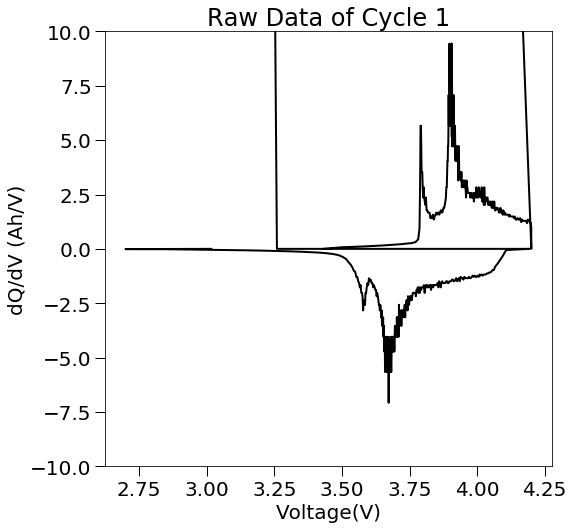

In [27]:
raw_data = ccf.load_sep_cycles(base_filename, database, datatype)
raw_df = raw_data[1] 
# user can change the index of raw_df to see other cycles

fig1 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

plt.plot(raw_df['Voltage(V)'], raw_df['dQ/dV'], c = 'black', linewidth = 2, label = 'Raw Cycle Data') 

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Raw Data of Cycle 1', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle_Raw Data.png', bbox_inches='tight', dpi = 600)

As we can see in the Raw data, there are several noise and jumps on both ends, So in order to eliminate those noise and jumps, we need to remove those data points which the dV value is about zero.


Therefore, we excute fuction `drop_inf_nan_dqdv` to drop rows where dV=0 (or about 0) in a dataframe that has already had dv calculated, then recalculates dV and calculates dQ/dV.

(-10, 10)

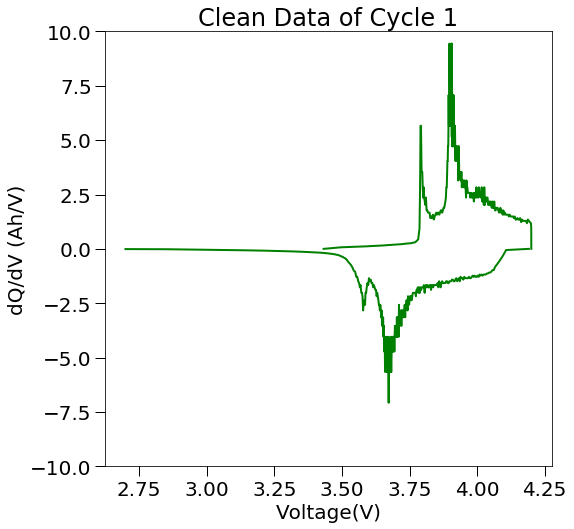

In [28]:
rawdf = ccf.init_columns(raw_df, datatype)
rawdf1 = ccf.calc_dq_dqdv(rawdf, datatype)
clean_df = ccf.drop_inf_nan_dqdv(rawdf1, datatype)

# Clean charge and discharge cycles separately: 
charge, discharge = ccf.sep_char_dis(clean_df, datatype)
charge = ccf.clean_charge_discharge_separately(charge, datatype)
discharge = ccf.clean_charge_discharge_separately(discharge, datatype)

fig2 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

plt.plot(charge['Voltage(V)'], charge['dQ/dV'], c = 'green', linewidth = 2, label = 'Clean Charge Cycle Data') 
plt.plot(discharge['Voltage(V)'], discharge['dQ/dV'], c = 'green', linewidth = 2, label = 'Clean Dishcarge Cycle Data') 

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Clean Data of Cycle 1', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle-Clean Data.png', bbox_inches='tight', dpi = 600)

In order to help the computer to recognize peaks more easily later, we need to apply the Savitzky-Golay Filter to  our data to get a nice and smooth curve.

Then, sperate cycles into charge and discharge cycles first, and apply the Savitzky–Golay filter to smooth the data:

(-10, 10)

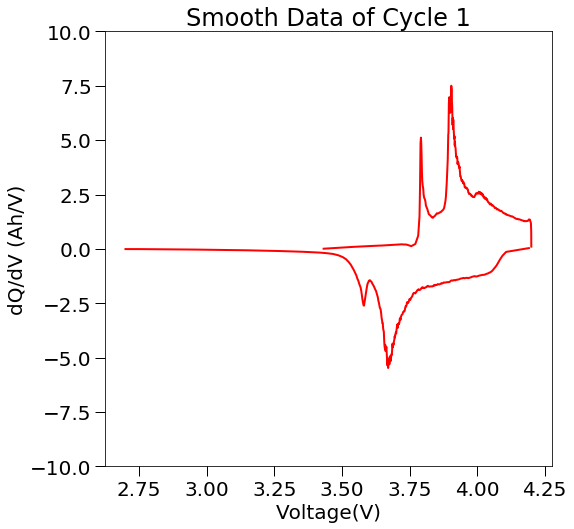

In [29]:
windowlength = 9
polyorder = 3

# apply Savitzky–Golay filter
if len(discharge) > windowlength:
    smooth_discharge = ccf.my_savgolay(discharge, windowlength, polyorder)
else:
    discharge['Smoothed_dQ/dV'] = discharge['dQ/dV']
    smooth_discharge = discharge
# this if statement is for when the datasets have less datapoints
# than the windowlength given to the sav_golay filter.
# without this if statement, the sav_golay filter throws an error
# when given a dataset with too few points. This way, we simply
# forego the smoothing function.
if len(charge) > windowlength:
    smooth_charge = ccf.my_savgolay(charge, windowlength, polyorder)
else:
    charge['Smoothed_dQ/dV'] = charge['dQ/dV']
    smooth_charge = charge
# same as above, but for charging cycles.

fig3 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Charge Cycle Data') 
plt.plot(discharge['Voltage(V)'], discharge['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Dishcarge Cycle Data') 

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Smooth Data of Cycle 1', fontsize = 24)

#plt.xlim(2.8, 4.2)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle_Smooth Data.png', bbox_inches='tight', dpi = 600)

### Peak Finding
Once we got the smooth data, we then apply the "peak_finder" function, which is based on an open source package "Peakutils" to locate the peaks for both charge and discharge data.

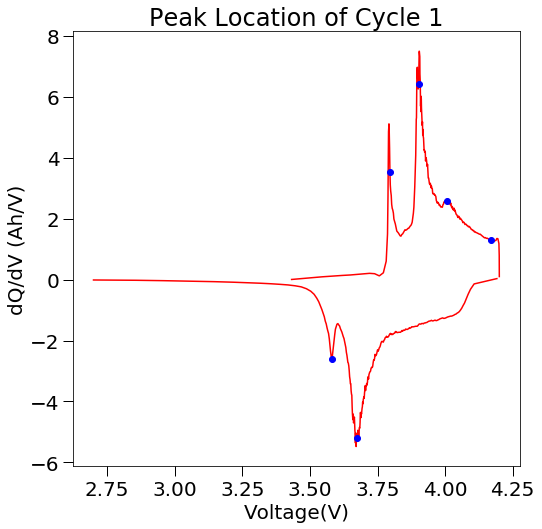

In [30]:
# we first create the column of the dataframe according to the datatype
(cycle_ind_col, data_point_col, volt_col, curr_col,
dis_cap_col, char_cap_col, charge_or_discharge) = ccf.col_variables(datatype)
chargeloc_dict = {}
param_df = pd.DataFrame(columns=['Cycle','Model_Parameters_charge','Model_Parameters_discharge'])

# and we determine the max length of the dataframe
if len(clean_df[cycle_ind_col].unique()) > 1:
    length_list = [len(clean_df[df_clean[cycle_ind_col] == cyc])
                   for cyc in clean_df[cycle_ind_col].unique() if cyc != 1]
    lenmax = max(length_list)
else:
    length_list = 1
    lenmax = len(clean_df)
    
import peakutils
import scipy.signal

peak_thresh=.3/max(charge['Smoothed_dQ/dV'])
    
# apply peak_finder
i_charge, volts_i_ch, peak_heights_c = dct.peak_finder(charge,'c', windowlength, polyorder, datatype, lenmax, peak_thresh)
i_discharge, volts_i_dic, peak_heights_d = dct.peak_finder(discharge,'d', windowlength, polyorder, datatype, lenmax, peak_thresh)

# set up a figure
fig4 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'r')
plt.plot(discharge['Voltage(V)'], discharge['Smoothed_dQ/dV'], 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Peak Location of Cycle 1', fontsize = 24)
plt.plot(charge['Voltage(V)'][i_charge], charge['Smoothed_dQ/dV'][i_charge], 'o', c='b')
plt.plot(discharge['Voltage(V)'][i_discharge], discharge['Smoothed_dQ/dV'][i_discharge], 'o', c='b')

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle_peak_finder.png', bbox_inches='tight', dpi = 600)

### Model Generation
Following that, we continued to apply functions "model_gen" and "model_eval" to generate models that fit those peaks, which generates a mixture of Pseudo-Voigt distributions with a 4th degree polynomial background is fitted to the peak.

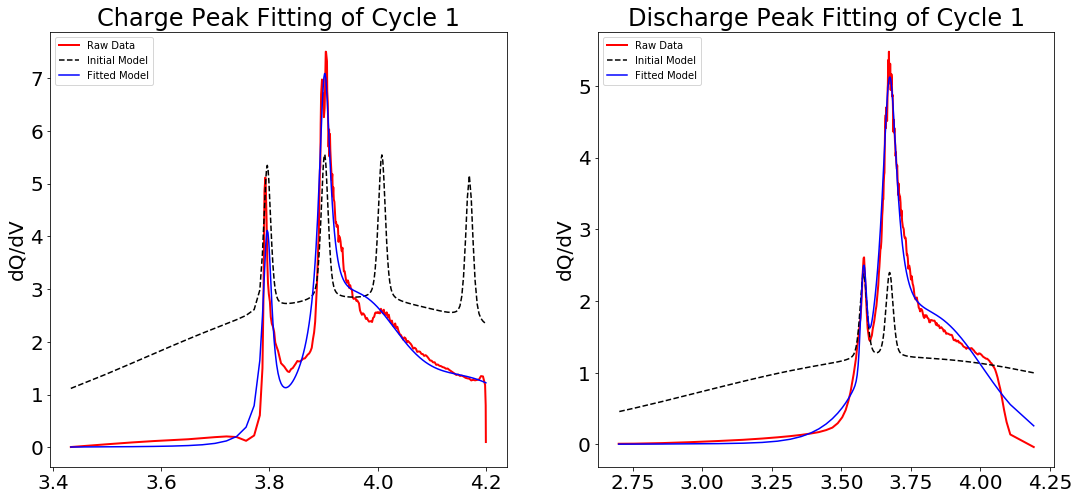

In [40]:
# change the number of cyc according to the cycle number
cyc = 1

# we first assign some variables in charge cycle
V_series_c = smooth_charge[volt_col]
dQdV_series_c = smooth_charge['Smoothed_dQ/dV']

# apply model_gen and model_eval to generate model and iritate from inital guess to the best fit
par_c, mod_c, indices_c = dct.model_gen(V_series_c, dQdV_series_c, 'c', i_charge, cyc, peak_thresh)
model_c = dct.model_eval(V_series_c, dQdV_series_c, 'c', par_c, mod_c)

if model_c is not None:
    mod_y_c = mod_c.eval(params=model_c.params, x=V_series_c)
    myseries_c = pd.Series(mod_y_c)
    myseries_c = myseries_c.rename('Model')
    model_c_vals = model_c.values
    new_df_mody_c = pd.concat([myseries_c, V_series_c, dQdV_series_c, smooth_charge[cycle_ind_col]], axis=1)
else:
    mod_y_c = None
    new_df_mody_c = None
    model_c_vals = None
    
# now the discharge
V_series_d = smooth_discharge[volt_col]
dQdV_series_d = smooth_discharge['Smoothed_dQ/dV']
par_d, mod_d, indices_d = dct.model_gen(V_series_d, dQdV_series_d, 'd', i_discharge, cyc, peak_thresh)
model_d = dct.model_eval(V_series_d, dQdV_series_d, 'd', par_d, mod_d)

if model_d is not None:
    mod_y_d = mod_d.eval(params=model_d.params, x=V_series_d)
    myseries_d = pd.Series(mod_y_d)
    myseries_d = myseries_d.rename('Model')
    new_df_mody_d = pd.concat([-myseries_d, V_series_d, dQdV_series_d, smooth_discharge[cycle_ind_col]], axis=1)
    model_d_vals = model_d.values
else:
    mod_y_d = None
    new_df_mody_d = None
    model_d_vals = None
    
if new_df_mody_c is not None or new_df_mody_d is not None:
    new_df_mody = pd.concat([new_df_mody_c, new_df_mody_d], axis=0)
else:
    new_df_mody = None

new_df_mody

# plots data
fig5 = plt.figure(figsize = (18,8), facecolor = 'w', edgecolor= 'k')

plt.subplot(1, 2, 1)
plt.plot(smooth_charge['Voltage(V)'], smooth_charge['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Data') 
plt.plot(smooth_charge['Voltage(V)'], model_c.init_fit, 'k--')
plt.plot(smooth_charge['Voltage(V)'], model_c.best_fit, 'b-')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Charge Peak Fitting of Cycle 1', fontsize = 24)
plt.legend(['Raw Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(smooth_discharge['Voltage(V)'], -smooth_discharge['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Data') 
plt.plot(smooth_discharge['Voltage(V)'], model_d.init_fit[::-1], 'k--')
plt.plot(smooth_discharge['Voltage(V)'], model_d.best_fit[::-1], 'b-')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Discharge Peak Fitting of Cycle 1', fontsize = 24)
plt.legend(['Raw Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle_generate model', bbox_inches='tight', dpi = 600)

So, the overall fit model with the raw data is shown below

(-10, 10)

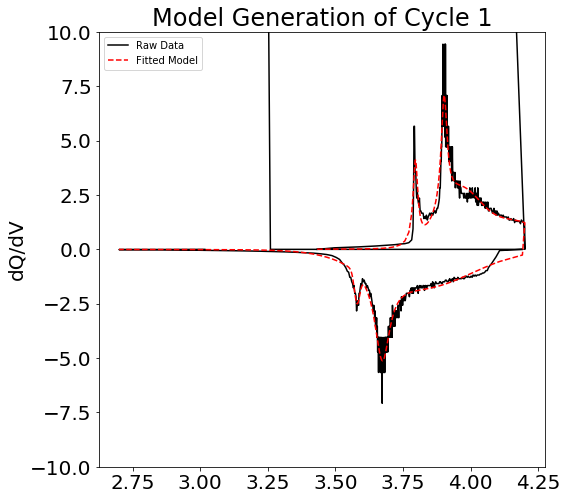

In [43]:
smooth_df = smooth_charge.append(smooth_discharge)

fig6 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

plt.plot(raw_df['Voltage(V)'], raw_df['dQ/dV'], 'k-', label = 'Raw Data') 
plt.plot(smooth_df['Voltage(V)'], new_df_mody['Model'], 'r--')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Model Generation of Cycle 1', fontsize = 24)
plt.legend(['Raw Data', 'Fitted Model'], loc=2, fontsize=10)

plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle_final generate model', bbox_inches='tight', dpi = 600)